In [7]:
from haystack import Pipeline
from haystack.document_stores.types import DuplicatePolicy
from haystack.components.builders.prompt_builder import PromptBuilder

from haystack.components.generators import OpenAIGenerator
# from haystack_integrations.components.generators.ollama import OllamaGenerator
from haystack_integrations.components.retrievers.qdrant import QdrantEmbeddingRetriever
from haystack_integrations.document_stores.qdrant import QdrantDocumentStore
from haystack.components.embedders import SentenceTransformersTextEmbedder, SentenceTransformersDocumentEmbedder

from datasets import load_dataset
from haystack import Document

In [5]:
document_store = QdrantDocumentStore(
    url='http://localhost:6333',
    recreate_index=True,
    return_embedding=True,
    wait_result_from_api=True
)

In [6]:
dataset = load_dataset("PaulAdversarial/all_news_finance_sm_1h2023", split="train")
documents = [Document(content=doc["title"]) for doc in dataset]

document_embedder = SentenceTransformersDocumentEmbedder()  
document_embedder.warm_up()
documents_with_embeddings = document_embedder.run(documents)

document_store.write_documents(documents_with_embeddings.get("documents"),policy=DuplicatePolicy.OVERWRITE)

Generating train split:   0%|          | 0/5062 [00:00<?, ? examples/s]

/home/name-1/anaconda3/lib/python3.11/site-packages/sentence_transformers/SentenceTransformer.py:174: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v3 of SentenceTransformers.
  warnings.warn(
/home/name-1/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/159 [00:00<?, ?it/s]

5100it [00:05, 974.37it/s]                           


5062

In [8]:
retriever = QdrantEmbeddingRetriever(document_store=document_store)

In [9]:
template = """
Given only the following information, answer the question.
Ignore your own knowledge.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}


Question: {{ query }}?
"""


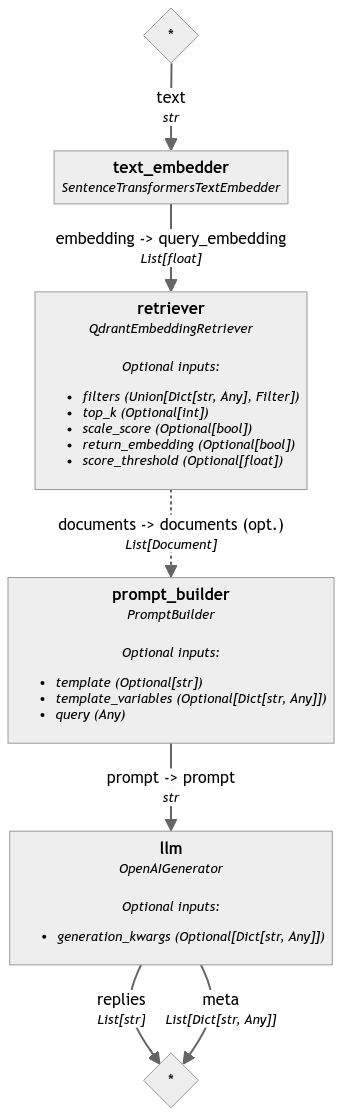

In [10]:
from haystack.utils import Secret
pipe = Pipeline()

generator = OpenAIGenerator(
    model="lmstudio-community/Meta-Llama-3.1-8B-Instruct-GGUF",
    api_base_url="http://10.2.125.37:1234/v1",
    api_key=Secret.from_token("lm-studio")
)

pipe.add_component("text_embedder", SentenceTransformersTextEmbedder())
pipe.add_component("retriever", retriever)
pipe.add_component("prompt_builder", PromptBuilder(template=template))
pipe.add_component("llm", generator)
pipe.connect("text_embedder.embedding", "retriever.query_embedding")
pipe.connect("retriever", "prompt_builder.documents")
pipe.connect("prompt_builder", "llm")
pipe.show()

In [11]:
query = "Give me all the news you have about IMAX"

response = pipe.run({"prompt_builder": {"query": query}, "text_embedder": {"text": query}})

print(response["llm"]["replies"])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

["I don't have any information about IMAX in the provided context. The articles and headlines mentioned do not include any mention of IMAX. If you would like to provide more context or information, I'll be happy to try and assist further."]
